<a href="https://colab.research.google.com/github/alwayswannadie1/Projects/blob/master/Copy_of_%D0%9D%D0%B8%D1%85%D1%83%D1%8F_%D0%BD%D0%B5_simple_%D1%84%D0%B8%D1%87%D0%B0_%D0%B8%D0%BD%D0%B6%D0%B8%D0%BD%D0%B8%D1%80%D0%B8%D0%BD%D0%B3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install shap

     |████████████████████████████████| 266kB 2.8MB/s 
  Created wheel for shap: filename=shap-0.34.0-cp36-cp36m-linux_x86_64.whl size=383172 sha256=8f0e985dd154be544f541844d222f0a1db7e760ab21611452587cdd6155305b3
  Stored in directory: /root/.cache/pip/wheels/28/7e/28/57bc9fcb77579b0df6561298648249370648c0b91dfe42c8ec
Successfully built shap


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score, GroupKFold
from sklearn.feature_selection import SelectFpr, SelectFdr
import numpy as np
import os
from matplotlib import pyplot as plt
import lightgbm as lgb
import copy
import gc
import xgboost as xgb
# import catboost as ctb
import warnings
warnings.filterwarnings('ignore')
import plotly.express as px
import shap
from tqdm import tqdm_notebook
import json
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
import mlxtend
from mlxtend.feature_selection import SequentialFeatureSelector
import random
random.seed(4)
# from bayes_opt import BayesianOptimization as BO
%matplotlib inline

In [0]:
gc.collect()

8

In [0]:
data_folder = './drive/My Drive/Boosters OneTwoTrip/share_data/'
subm_folder = './drive/My Drive/Boosters OneTwoTrip/Task 2/submissions'

In [0]:
# df_train = pd.read_csv(os.path.join(data_folder, 'train_features.csv'))
# df_test = pd.read_csv(os.path.join(data_folder,'test_features.csv'))
df_train = pd.read_pickle(os.path.join(data_folder, 'train_features.pkl'))
df_test = pd.read_pickle(os.path.join(data_folder, 'test_features.pkl'))

In [0]:
df_train.field12_mean_div.iloc[3]

1.555556

In [0]:
gc.collect()

0

In [0]:
with open(os.path.join(data_folder, 'features.txt'), 'r') as f:
    features = json.load(f)

In [0]:
features.keys()

dict_keys(['fields_cols', 'dif_cols', 'shift_cols', 'just_cols', 'ind_cols', 'encode_cols', 'div_cols', 'mix_cols'])

In [0]:
gc.collect()

118

In [0]:
features['fields_cols']

['field0',
 'field1',
 'field2',
 'field3',
 'field4',
 'field5',
 'field6',
 'field7',
 'field8',
 'field9',
 'field10',
 'field11',
 'field12',
 'field13',
 'field14',
 'field15',
 'field16',
 'field17',
 'field18',
 'field19',
 'field20',
 'field21',
 'field22',
 'field23',
 'field24',
 'field25',
 'field26',
 'field27',
 'field28',
 'field29',
 'field1_1',
 'field14_1']

In [0]:
df_train.shape

(196056, 733)

- Вернуть из старого сабмита goal23 и goal25???

In [0]:
for col in df_train.columns:
    if np.inf in df_train[col]:
        print(col)

In [0]:
# не работает эта хуета
def make_encoding_great_again(train_df, test_df):
    
    all_df = pd.concat([train_df, test_df])

    # by_encode = ['field16', 'field12', 'field0', 'field1']
    # for_encode = ['field0', 'field1', 'field12', 'field16', 'field15']

    by_encode = ['userid', 'field5', 'field4', 'field1']
    for_encode = ['field1_1', 'field13', 'field16']

    for col_by in by_encode:
        for col_for in for_encode:
            if col_for != col_by:
                
                all_df[col_by + '_mean_enc_' + col_for] = all_df[[col_by, col_for]].groupby(col_by)[col_for].transform('mean')
                all_df[col_by + '_mean_div_enc_' + col_for] = all_df[col_for]/all_df[col_by + '_mean_enc_' + col_for]
                print(f'field {col_for} encode by {col_by}')
    all_df.replace({np.inf:-9999, -np.inf:-9999})
    return all_df[all_df.userid.isin(train_df.userid.unique())], all_df[all_df.userid.isin(test_df.userid.unique())]


def get_encode_features(train_df, test_df, cols_to_mix):
    all_df = pd.concat([train_df, test_df], ignore_index=True)

    # all_df['field_0_value_encode'] = all_df.groupby('field0')['orderid'].transform('count')

    # all_df['field_12_value_encode'] = all_df.groupby('field12')['orderid'].transform('count')
    # all_df['field_16_value_encode'] = all_df.groupby('field16')['orderid'].transform('count')

    # all_df['field_12_value_encode_userid'] = all_df.groupby(['userid', 'field12'])['orderid'].transform('count')
    # all_df['field_16_value_encode_userid'] = all_df.groupby(['userid', 'field16'])['orderid'].transform('count')

    # groupby mean и отношения по field6_mix_field14 и field6_mix_field12
    # не работает, но и не портит (не буду выкидывать пока)
    # fields_for_test = ['field16', 'field1_1', 'field12']
    # for col in fields_for_test:
    #     all_df[col+'_mean_div_enc_field6_14'] = all_df.groupby('field6_mix_field14')[col].transform('mean')
    #     all_df[col+'_mean_div_enc_field6_14'] = all_df[col+'_mean_div_enc_field6_14']/all_df[col]

    #     all_df[col+'_mean_div_enc_field6_12'] = all_df.groupby('field6_mix_field12')[col].transform('mean')
    #     all_df[col+'_mean_div_enc_field6_12'] = all_df[col+'_mean_div_enc_field6_12']/all_df[col]

    # value_counts
    fields_for_counts = ['field1', 'field6', 'field12', 'field13', 'field16', 'field22']
    for col in fields_for_counts:
        all_df[col+'_value_counts'] = all_df.groupby(col)['userid'].transform('count')

    # groupby по месяцу, году и дню недели покупки ()
    # fields_for_mean = ['field1_1', 'field14_1', 'field22', 'field6', 'field13', 'field15']
    # fields_for_mean = ['indicator_goal22', 'indicator_goal23', 'indicator_goal24', 'indicator_goal25']
    # for col in fields_for_mean:
    #     all_df[col+'_mean_time_buy'] = all_df.groupby(['field2', 'field18', 'field21'])[col].transform('mean')
    #     all_df[col+'_mean_time_buy_div'] = all_df[col+'_mean_time_buy']/all_df[col]

    # groupby по часу и дню недели отлета
    # fields_for_mean = ['field1_1', 'field14_1', 'field22', 'field6', 'field13', 'field15']
    # fields_for_mean = ['indicator_goal22', 'indicator_goal23', 'indicator_goal24', 'indicator_goal25']
    # for col in fields_for_mean:
    #     all_df[col+'_mean_time_fly'] = all_df.groupby(['field3', 'field20', 'field23'])[col].transform('mean')
    #     all_df[col+'_std_time_fly'] = all_df.groupby(['field3', 'field20', 'field23'])[col].transform('std')
    #     all_df[col+'_mean_time_fly_div'] = all_df[col+'_mean_time_fly']/all_df[col]

    # groupby по количеству билетов и field14
    fields_for_mean = ['field1_1', 'field22', 'field6', 'field13', 'field15', 'field17', 'field26', 
                       'indicator_goal21', 'indicator_goal22', 'indicator_goal23', 'indicator_goal24', 'indicator_goal25']
    for col in fields_for_mean:
        all_df[col+'_mean_tickets'] = all_df.groupby(['field15', 'field14'])[col].transform('mean')
        all_df[col+'_mean_tickets_div'] = all_df[col+'_mean_tickets']/all_df[col]

    all_df['tickets_grown_perc'] = all_df['field24']/all_df['field15']
    all_df['price_of_tickects'] = all_df['field1_1']/all_df['field15']
    all_df['tickets_child_perc'] = (all_df['field28'])/all_df['field15']

    all_df = get_add_encode_mean(all_df)
    all_df = get_encode_prices_mean(all_df)
    

    # all_df = all_mix_up(all_df, cols_to_mix)

    return all_df[all_df.userid.isin(train_df.userid.unique())], all_df[all_df.userid.isin(test_df.userid.unique())]


def all_mix_up(all_df, cols_to_mix):
    n = 0
    for i in range(len(cols_to_mix)):
        for j in range(i+1, len(cols_to_mix)):
            c1 = cols_to_mix[i]
            c2 = cols_to_mix[j]
            new_col_name = c1 + '_mix_' + c2
            all_df[new_col_name] = all_df[c1].astype(str) + all_df[c2].astype(str)
            all_df[new_col_name] = all_df.groupby(new_col_name)['orderid'].transform('count')
            n+=1
        
        print(f'col {cols_to_mix[i]} done num of feats {n}')
    return all_df

def mix_up_part_2(train_df, test_df, cols_1, cols_2):
    all_df = pd.concat([train_df, test_df], ignore_index=True)
    for i in tqdm_notebook(range(len(cols_1))):
        for j in tqdm_notebook(range(len(cols_2)), leave=False):
            c1 = cols_1[i]
            c2 = cols_2[j]
            if c1!=c2:
                new_col_name = c1 + '_newmix_' + c2
                all_df[new_col_name] = all_df[c1].astype(str) + all_df[c2].astype(str)
                all_df[new_col_name] = all_df.groupby(new_col_name)['orderid'].transform('count')
    return all_df[all_df.userid.isin(train_df.userid.unique())], all_df[all_df.userid.isin(test_df.userid.unique())] 


def get_add_encode_mean(all_df):
    features_to_encode = ['field1', 'field14', 'field25', 'field26', 'field27']
    features_by_encode = ['field1', 'field14', 'field25', 'field26', 'field27', 'field4']
    for feat_by in tqdm_notebook(features_by_encode):
        for feat_to in features_to_encode:
            if feat_to != feat_by:
                all_df[feat_to+'_mean_encode_' + feat_by] = all_df.groupby(feat_by)[feat_to].transform('mean')
                all_df[feat_to+'_mean_encode_' + feat_by+'_div'] = all_df[feat_to]/all_df[feat_to+'_mean_encode_' + feat_by]
    return all_df

def get_encode_prices_mean(all_df):
    features_by_encode = copy.copy(features['fields_cols']) + features['ind_cols']
    features_by_encode.remove('field1_1')
    features_by_encode.remove('field14_1')
    features_to_encode = ['field1', 'field14', 'field27', 'field16', 'field12']
    for feat_by in tqdm_notebook(features_by_encode):
        for feat_to in features_to_encode:
            new_col = feat_to+'_mean_encode_' + feat_by
            if feat_to != feat_by and new_col not in all_df.columns :
                all_df[new_col] = all_df.groupby(feat_by)[feat_to].transform('mean')
                all_df[new_col+'_div'] = all_df[feat_to]/all_df[new_col]
    return all_df

In [0]:
# df_train, df_test = make_encoding_great_again(df_train, df_test)

In [0]:
df_train, df_test = get_encode_features(df_train, df_test, [])

In [0]:
# a = copy.copy(features['fields_cols'])
# a.remove('field6')
# a.remove('field14')
# df_train, df_test = mix_up_part_2(df_train, df_test, ['field6_mix_field14'], a)

In [0]:
# Фичи Марка (не работают)
# df_train['field2_mdiv_field12'] = (df_train['field2']/df_train['field12']).round(3)
# df_test['field2_mdiv_field12'] = (df_test['field2']/df_test['field12']).round(3)

# df_train['field3_mdiv_field18'] = df_train['field3']/df_train['field18']
# df_test['field3_mdiv_field18'] = df_test['field3']/df_test['field18']

# df_train['field2_mdiv_field14'] = df_train['field2']/df_train['field14']
# df_test['field2_mdiv_field14'] = df_test['field2']/df_test['field14']

# df_train['field13_mdiv_field4'] = df_train['field13']/df_train['field4']
# df_test['field13_mdiv_field4'] = df_test['field13']/df_test['field4']

# df_train['field2_mdiv_field20'] = df_train['field2']/df_train['field20']
# df_test['field2_mdiv_field20'] = df_test['field2']/df_test['field20']

# df_train['field22_mdiv_field29'] = df_train['field22']/df_train['field29']
# df_test['field22_mdiv_field29'] = df_test['field22']/df_test['field29']

# df_train['field25_mdiv_field12'] = df_train['field25']/df_train['field12']
# df_test['field25_mdiv_field12'] = df_test['field25']/df_test['field12']

In [0]:
# фичи с индикаторами и userid
# не работает!(( и очень долго считается (16 минут цикл)
# работают для первой задачи! не работают для второй

# indicators = copy.copy(features['ind_cols'])
# indicators.remove('indicator_goal21')
# for ind_col in tqdm_notebook(indicators):
    
#     df_train[ind_col + '_mean_userid'] = df_train[['userid', ind_col]].groupby('userid').transform('mean')
#     df_test[ind_col + '_mean_userid'] = df_test[['userid', ind_col]].groupby('userid').transform('mean')

#     df_train[ind_col + '_rolling_3_mean_userid'] = df_train[['userid', ind_col]].groupby('userid')[ind_col].rolling(3, min_periods=2).mean().reset_index(0,drop=True)
#     df_test[ind_col + '_rolling_3_mean_userid'] = df_test[['userid', ind_col]].groupby('userid')[ind_col].rolling(3, min_periods=2).mean().reset_index(0,drop=True)

#     df_train[ind_col + '_rolling_3_mean_shift_userid'] = df_train[['userid', ind_col]].groupby('userid')[ind_col].shift().rolling(3, min_periods=1).mean().reset_index(0,drop=True)
#     df_test[ind_col + '_rolling_3_mean_shift_userid'] = df_test[['userid', ind_col]].groupby('userid')[ind_col].shift().rolling(3, min_periods=1).mean().reset_index(0,drop=True)
#     gc.collect()

In [0]:
df_train = df_train.replace([np.inf, -np.inf], -9999)
df_train = df_train.fillna(-999)

df_test = df_test.replace([np.inf, -np.inf], -9999)
df_test = df_test.fillna(-999)

In [0]:
gc.collect()

0

### Валидация

In [0]:
# new_enc_cols = list(filter(lambda x: '_mean_enc_' in x, df_train.columns))
# new_div_cols = list(filter(lambda x: '_mean_div_enc_' in x, df_train.columns))
# new_mix_cols = list(filter(lambda x: '_newmix_' in x , df_train.columns))
# new_mark_cols = list(filter(lambda x: 'mdiv' in x , df_train.columns))
# new_ind_rol_cols = list(filter(lambda x: 'indicator' in x and 'rolling' in x , df_train.columns))
# new_ind_mean_cols = list(filter(lambda x: 'indicator' in x and 'mean' in x , df_train.columns))
new_div_enc_cols = list(filter(lambda x: '_mean_div_enc_' in x , df_train.columns))
new_count_cols = list(filter(lambda x: '_value_counts' in x , df_train.columns))
new_time_groupby_cols = list(filter(lambda x: '_mean_time_buy' in x or '_time_fly' in x, df_train.columns))
new_tickets_cols = list(filter(lambda x:  'tickets' in x, df_train.columns))
mean_encode_cols = list(filter(lambda x: 'mean_encode' in x, df_train.columns))

In [0]:
mean_encode_cols

['field14_mean_encode_field1',
 'field14_mean_encode_field1_div',
 'field25_mean_encode_field1',
 'field25_mean_encode_field1_div',
 'field26_mean_encode_field1',
 'field26_mean_encode_field1_div',
 'field27_mean_encode_field1',
 'field27_mean_encode_field1_div',
 'field1_mean_encode_field14',
 'field1_mean_encode_field14_div',
 'field25_mean_encode_field14',
 'field25_mean_encode_field14_div',
 'field26_mean_encode_field14',
 'field26_mean_encode_field14_div',
 'field27_mean_encode_field14',
 'field27_mean_encode_field14_div',
 'field1_mean_encode_field25',
 'field1_mean_encode_field25_div',
 'field14_mean_encode_field25',
 'field14_mean_encode_field25_div',
 'field26_mean_encode_field25',
 'field26_mean_encode_field25_div',
 'field27_mean_encode_field25',
 'field27_mean_encode_field25_div',
 'field1_mean_encode_field26',
 'field1_mean_encode_field26_div',
 'field14_mean_encode_field26',
 'field14_mean_encode_field26_div',
 'field25_mean_encode_field26',
 'field25_mean_encode_field26_div',
 'field27_mean_encode_field26',
 'field27_mean_encode_field26_div',
 'field1_mean_encode_field27',
 'field1_mean_encode_field27_div',
 'field14_mean_encode_field27',
 'field14_mean_encode_field27_div',
 'field25_mean_encode_field27',
 'field25_mean_encode_field27_div',
 'field26_mean_encode_field27',
 'field26_mean_encode_field27_div',
 'field1_mean_encode_field4',
 'field1_mean_encode_field4_div',
 'field14_mean_encode_field4',
 'field14_mean_encode_field4_div',
 'field25_mean_encode_field4',
 'field25_mean_encode_field4_div',
 'field26_mean_encode_field4',
 'field26_mean_encode_field4_div',
 'field27_mean_encode_field4',
 'field27_mean_encode_field4_div',
 'field1_mean_encode_field0',
 'field1_mean_encode_field0_div',
 'field14_mean_encode_field0',
 'field14_mean_encode_field0_div',
 'field27_mean_encode_field0',
 'field27_mean_encode_field0_div',
 'field16_mean_encode_field0',
 'field16_mean_encode_field0_div',
 'field12_mean_encode_field0',
 'field12_mean_encode_field0_div',
 'field16_mean_encode_field1',
 'field16_mean_encode_field1_div',
 'field12_mean_encode_field1',
 'field12_mean_encode_field1_div',
 'field1_mean_encode_field2',
 'field1_mean_encode_field2_div',
 'field14_mean_encode_field2',
 'field14_mean_encode_field2_div',
 'field27_mean_encode_field2',
 'field27_mean_encode_field2_div',
 'field16_mean_encode_field2',
 'field16_mean_encode_field2_div',
 'field12_mean_encode_field2',
 'field12_mean_encode_field2_div',
 'field1_mean_encode_field3',
 'field1_mean_encode_field3_div',
 'field14_mean_encode_field3',
 'field14_mean_encode_field3_div',
 'field27_mean_encode_field3',
 'field27_mean_encode_field3_div',
 'field16_mean_encode_field3',
 'field16_mean_encode_field3_div',
 'field12_mean_encode_field3',
 'field12_mean_encode_field3_div',
 'field16_mean_encode_field4',
 'field16_mean_encode_field4_div',
 'field12_mean_encode_field4',
 'field12_mean_encode_field4_div',
 'field1_mean_encode_field5',
 'field1_mean_encode_field5_div',
 'field14_mean_encode_field5',
 'field14_mean_encode_field5_div',
 'field27_mean_encode_field5',
 'field27_mean_encode_field5_div',
 'field16_mean_encode_field5',
 'field16_mean_encode_field5_div',
 'field12_mean_encode_field5',
 'field12_mean_encode_field5_div',
 'field1_mean_encode_field6',
 'field1_mean_encode_field6_div',
 'field14_mean_encode_field6',
 'field14_mean_encode_field6_div',
 'field27_mean_encode_field6',
 'field27_mean_encode_field6_div',
 'field16_mean_encode_field6',
 'field16_mean_encode_field6_div',
 'field12_mean_encode_field6',
 'field12_mean_encode_field6_div',
 'field1_mean_encode_field7',
 'field1_mean_encode_field7_div',
 'field14_mean_encode_field7',
 'field14_mean_encode_field7_div',
 'field27_mean_encode_field7',
 'field27_mean_encode_field7_div',
 'field16_mean_encode_field7',
 'field16_mean_encode_field7_div',
 'field12_mean_encode_field7',
 'field12_mean_encode_field7_div',
 'field1_mean_encode_field8',
 'field1_mean_encode_field8_div',
 'field14_mean_encode_field8',
 

In [0]:
np.random.seed(0)

In [0]:
xgb_cl = xgb.XGBClassifier(random_state=1488)
# cat_cl = ctb.CatBoostClassifier(random_state=1488, verbose=False)
params = {'colsample_bytree': 0.8856,
 'learning_rate': 0.0113,
 'max_depth': 5,
 'n_estimators': 400,
 'num_leaves': 59,
 'reg_lambda': 0.1124,
 'subsample': 0.599}
lgb_cl = lgb.LGBMClassifier(**params, random_state=10, n_jobs=-1)
rf = RandomForestClassifier(n_estimators=150, random_state=1488)

In [0]:
# targets = ['goal22']
targets = ['goal21', 'goal22', 'goal23', 'goal24', 'goal25']
# targets = ['goal21', 'goal22']

In [0]:
models = {
    # 'xgb': xgb_cl,
    # 'ctb': cat_cl,
    'lgb': lgb_cl,
    # 'rf': rf
}

In [0]:
scores = {}
targs = {}
for tar in targets:
    targs[tar] = []
for model in models:
    scores[model] = targs

In [0]:
cv = GroupKFold(n_splits=3)

In [0]:
variable_names = []
for key in features.keys():
    if key != 'mix_cols':
        variable_names += features[key]

In [0]:
variable_names += (new_count_cols + new_tickets_cols+new_time_groupby_cols+mean_encode_cols)

In [0]:
len(variable_names)

607

In [0]:
with open(os.path.join(data_folder, 'mix_best_features.txt'), 'r') as f:
    mix_best_features = json.load(f)

In [0]:
for best_ind in tqdm_notebook(mix_best_features['best_mix_inds']):
    a = features['mix_cols'][int(best_ind)]
    variable_names += [a]
    # print(a)

In [0]:
features['mix_cols'][int(best_ind)]

'field27_mix_field14_1'

In [0]:
# variable_names = features['fields_cols'] + features['ind_cols'] + features['just_cols'] + new_count_cols+ features['mix_cols'] + features['dif_cols'] + features['encode_cols'] + features['div_cols'] + new_tickets_cols

In [0]:
features.keys()

dict_keys(['fields_cols', 'dif_cols', 'shift_cols', 'just_cols', 'ind_cols', 'encode_cols', 'div_cols', 'mix_cols'])

In [0]:
# var_names = {
#     'goal21' : features['fields_cols'] + features['ind_cols'] + features['just_cols'] + new_count_cols,
#     'goal22' : features['fields_cols'] + features['dif_cols'] + features['ind_cols'] + new_count_cols + features['mix_cols'],
#     'goal23' : features['fields_cols'] + features['ind_cols'] + features['just_cols'] + new_count_cols + features['mix_cols'],
#     'goal24' : features['fields_cols'] + features['ind_cols'] + features['just_cols'] + new_count_cols + features['mix_cols'],
#     'goal25' : features['fields_cols'] + features['ind_cols'] + new_count_cols + features['mix_cols']
# }

In [0]:
# variable_names.remove('field12')
# variable_names.remove('field16')
# variable_names.remove('field0')

In [0]:
len(variable_names)

781

Гипотезы
1. подумать над индикаторами (пока не работают)
2. ролинги
3. что такое field6? 
4. следующий уровнеь интеракций
5. фичи по времени полета-улета, дситанции и т.д. (осознанные фичи)


In [0]:
# df_train.replace({np.inf:-999, -np.inf:-999}, inplace=True)
# df_test.replace({np.inf:-999, -np.inf:-999}, inplace=True)

In [0]:
# df_train.fillna(-999, inplace=True)
# df_test.fillna(-999, inplace=True)

In [0]:
# with open(os.path.join(data_folder, 'goal21_top_49_features.txt'), 'r') as f:
#     variable_names = json.load(f)
# with open(os.path.join(data_folder, 'features_type.txt'), 'r') as f:
#     types = json.load(f)

In [0]:
df_train.isnull().sum().sum()

0

((244,), (296,))

In [0]:
i = 0
for target in targets:
    df_train[target+'_oof'] = 0
    for train_index, test_index in cv.split(df_train, np.array(df_train.goal1), df_train.userid):
        
        train = df_train.iloc[train_index]
        # train = train.loc[train.indicator_goal22==1]
        test = df_train.iloc[test_index]
        i+=1

        for model in models:

            models[model].fit(train[variable_names], train[target])
            preds =  np.array(models[model].predict_proba(test[variable_names])[:,1])
            # preds = preds*np.array(test.indicator_goal22)
            scr = round(roc_auc_score(test[target], preds),4)

            scores[model][target].append(scr)

            df_train.loc[df_train.orderid.isin(test.orderid), target+'_oof'] = scr

            print(f'Model {model} target {target} on fold {i} has score {scr}')
        print('-'*20)

Model lgb target goal21 on fold 1 has score 0.7093
--------------------
Model lgb target goal21 on fold 2 has score 0.7266
--------------------
Model lgb target goal21 on fold 3 has score 0.7183
--------------------
Model lgb target goal22 on fold 4 has score 0.7184
--------------------
Model lgb target goal22 on fold 5 has score 0.7282
--------------------
Model lgb target goal22 on fold 6 has score 0.7272
--------------------
Model lgb target goal23 on fold 7 has score 0.893
--------------------
Model lgb target goal23 on fold 8 has score 0.8942
--------------------
Model lgb target goal23 on fold 9 has score 0.8925
--------------------
Model lgb target goal24 on fold 10 has score 0.7946
--------------------
Model lgb target goal24 on fold 11 has score 0.8013
--------------------
Model lgb target goal24 on fold 12 has score 0.7929
--------------------
Model lgb target goal25 on fold 13 has score 0.942
--------------------
Model lgb target goal25 on fold 14 has score 0.9387
----------

1. Model lgb target goal21 on fold 1 has score 0.7083
2. Model lgb target goal21 on fold 2 has score 0.7263
3. Model lgb target goal21 on fold 3 has score 0.7167
4. Model lgb target goal22 on fold 4 has score 0.7175
5. Model lgb target goal22 on fold 5 has score 0.7278
6. Model lgb target goal22 on fold 6 has score 0.7263
7. Model lgb target goal23 on fold 7 has score 0.8903
8. Model lgb target goal23 on fold 8 has score 0.8927
9. Model lgb target goal23 on fold 9 has score 0.8909
10. Model lgb target goal24 on fold 10 has score 0.792
11. Model lgb target goal24 on fold 11 has score 0.7998
12. Model lgb target goal24 on fold 12 has score 0.789
13. Model lgb target goal25 on fold 13 has score 0.9394
14. Model lgb target goal25 on fold 14 has score 0.9357
15. Model lgb target goal25 on fold 15 has score 0.9387

In [0]:
  for scr in scores:
    for trg in scores[scr]:
        print(f'Model {scr} target {trg} mean score {round(np.mean(scores[scr][trg]), 4)}')

In [0]:
df_train.rename({'goal21_score':'goal21', 'goal22_score':'goal22', 'goal23_score':'goal23', 'goal24_score':'goal24', 'goal25_score':'goal25'}, axis=1, inplace=True)
df_train.rename({'goal21_oof':'goal21_score', 'goal22_oof':'goal22_score', 'goal23_oof':'goal23_score', 'goal24_oof':'goal24_score', 'goal25_oof':'goal25_score'}, axis=1, inplace=True)

In [0]:
goals = ['goal21', 'goal22', 'goal23', 'goal24', 'goal25']
goals_scores = [goal + '_score' for goal in goals]

In [0]:
df_train[['userid', 'goal1'] + goals_scores + goals].head()

,userid,goal1,goal21_score,goal22_score,goal23_score,goal24_score,goal25_score,goal21,goal22,goal23,goal24,goal25
0,0,0.0,0.7167,0.7261,0.8935,0.7899,0.9401,0.0,1.0,0.0,0.0,0.0
1,1,0.0,0.7167,0.7261,0.8935,0.7899,0.9401,0.0,0.0,0.0,0.0,0.0
2,1,0.0,0.7167,0.7261,0.8935,0.7899,0.9401,0.0,0.0,0.0,0.0,0.0
3,2,0.0,0.7237,0.7262,0.8934,0.7951,0.9388,0.0,1.0,0.0,0.0,0.0
4,2,0.0,0.7237,0.7262,0.8934,0.7951,0.9388,0.0,0.0,0.0,0.0,0.0


In [0]:
df_train[['userid', 'goal1'] + goals_scores+goals].to_csv(os.path.join(subm_folder, 'oof_scores.csv'), index=False)

### Вторая задача ауки
- 0.7149
- 0.7195
- 0.893
- 0.7918
- 0.9402

- goal 1 0.709 (3 фолда) 0.711 с индикаторами

### Feature Selection for goal21

In [0]:
features.keys()

dict_keys(['fields_cols', 'dif_cols', 'shift_cols', 'just_cols', 'ind_cols', 'encode_cols', 'div_cols', 'mix_cols', 'new_count_cols', 'new_time_groupby_cols'])

In [0]:
new_count_cols = list(filter(lambda x: '_value_counts' in x , df_train.columns))
new_time_groupby_cols = list(filter(lambda x: '_mean_time_buy' in x , df_train.columns))

In [0]:
features['new_count_cols'] = new_count_cols
features['new_time_groupby_cols'] = new_time_groupby_cols

lgb_cl_for_sel = lgb.LGBMClassifier(random_state=10)

In [0]:
def select_features_group(model, train, features_groups):
    selected_groups = []
    temp_auc = 0
    i=0
    while i==0:
        selected_group, best_auc = one_step(features_groups, selected_groups, model, train, temp_auc)
        if selected_group is None:
            i=1
            print('End Searching')
        else:
            print(f'Selected group is {selected_group} with auc {best_auc}')
            selected_groups.append(selected_group)
            temp_auc = best_auc
    return selected_groups


def one_step(features_groups, selected_groups, model, train, temp_auc=0):
    selected_group = None
    selected_features = []

    for group in selected_groups:
        selected_features += features_groups[group]

    for group in tqdm_notebook(features_groups, leave=False):
        if group not in selected_groups:
            a = cross_val_score(model, train[selected_features+features_groups[group]], train['goal25'], groups=train['userid'], cv=GroupKFold(3), scoring='roc_auc')
            auc = np.mean(a)
            if auc> temp_auc:
                selected_group=group
                temp_auc = auc
    return selected_group, temp_auc

In [0]:
features_groups = copy.copy(features)

In [0]:
features_groups.pop('mix_cols')
features_groups.keys()

dict_keys(['fields_cols', 'dif_cols', 'shift_cols', 'just_cols', 'ind_cols', 'encode_cols', 'div_cols', 'new_count_cols', 'new_time_groupby_cols'])

In [0]:
a = select_features_group(lgb_cl_for_sel, df_train, features_groups=features_groups)

Selected group is fields_cols with auc 0.9265096038019799


Selected group is ind_cols with auc 0.9353442453369133


Selected group is new_count_cols with auc 0.9370733692072869


End Searching


In [0]:
a

['fields_cols', 'ind_cols', 'new_count_cols', 'just_cols']

In [0]:
cv_gen = GroupKFold(n_splits=2).split(df_train[variable_names], df_train['goal21'], df_train.userid)
lgb_cl_for_sfs = lgb.LGBMClassifier(random_state=1488, importance_type='gain') 

In [0]:
a = list(cv_gen)

In [0]:
lgb_cl_for_sfs.fit(df_train.iloc[a[0][0]][variable_names], df_train.iloc[a[0][0]]['goal21'])

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='gain', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=1488, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [0]:
round(roc_auc_score(df_train.iloc[a[0][1]]['goal21'], lgb_cl_for_sfs.predict_proba(df_train.iloc[a[0][1]][variable_names])[:,1]),4)

0.6901

In [0]:
sfs = SequentialFeatureSelector(lgb_cl_for_sfs, k_features=(10,150), verbose=1, scoring='roc_auc', n_jobs=-1, cv=a)

In [0]:
sfs.fit(df_train[variable_names], df_train['goal21'])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   35.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 722 out of 722 | elapsed: 10.4min finished
Features: 1/150[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   43.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 721 out of 721 | elapsed: 11.1min finished
Features: 2/150[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   42.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 720 out of 720

SequentialFeatureSelector(clone_estimator=True,
                          cv=[(array([     0,      3,      4, ..., 196051, 196053, 196054]),
                               array([     1,      2,      8, ..., 196050, 196052, 196055])),
                              (array([     1,      2,      8, ..., 196050, 196052, 196055]),
                               array([     0,      3,      4, ..., 196051, 196053, 196054]))],
                          estimator=LGBMClassifier(boosting_type='gbdt',
                                                   class_weight=None,
                                                   colsample_bytree=1.0,
                                                   importance_type='gain',
                                                   learning_rate=0.1,
                                                   max_depth=-1,
                                                   min_child_samples=20,
                                                   min_child_weight=0.001,
   

In [0]:
sfs.get_metric_dict()[10]

{'avg_score': 0.7071218290261331,
 'ci_bound': 0.024171005751041245,
 'cv_scores': array([0.70150413, 0.71273953]),
 'feature_idx': (116, 169, 361, 372, 395, 473, 552, 688, 689, 721),
 'feature_names': ('shift1_field14',
  'shiftminus_field27',
  'field4_mix_field29',
  'field5_mix_field14',
  'field6_mix_field12',
  'field9_mix_field21',
  'field13_mix_field22',
  'field24_mix_field26',
  'field24_mix_field27',
  'field25_mdiv_field12'),
 'std_dev': 0.005617698491679035,
 'std_err': 0.005617698491679034}

In [0]:
import json
with open(os.path.join(data_folder, 'goal21_top_10_features.txt'), 'w') as f:
    json.dump(sfs.get_metric_dict()[10]['feature_names'], f)

In [0]:
with open(os.path.join(data_folder, 'goal21_top_10_features.txt'), 'r') as f:
    a = json.load(f)

In [0]:
a

['shift1_field14',
 'shiftminus_field27',
 'field4_mix_field29',
 'field5_mix_field14',
 'field6_mix_field12',
 'field9_mix_field21',
 'field13_mix_field22',
 'field24_mix_field26',
 'field24_mix_field27',
 'field25_mdiv_field12']

In [0]:
explainer = shap.TreeExplainer(lgb_cl)

In [0]:
shap_values = explainer.shap_values(test[variable_names])

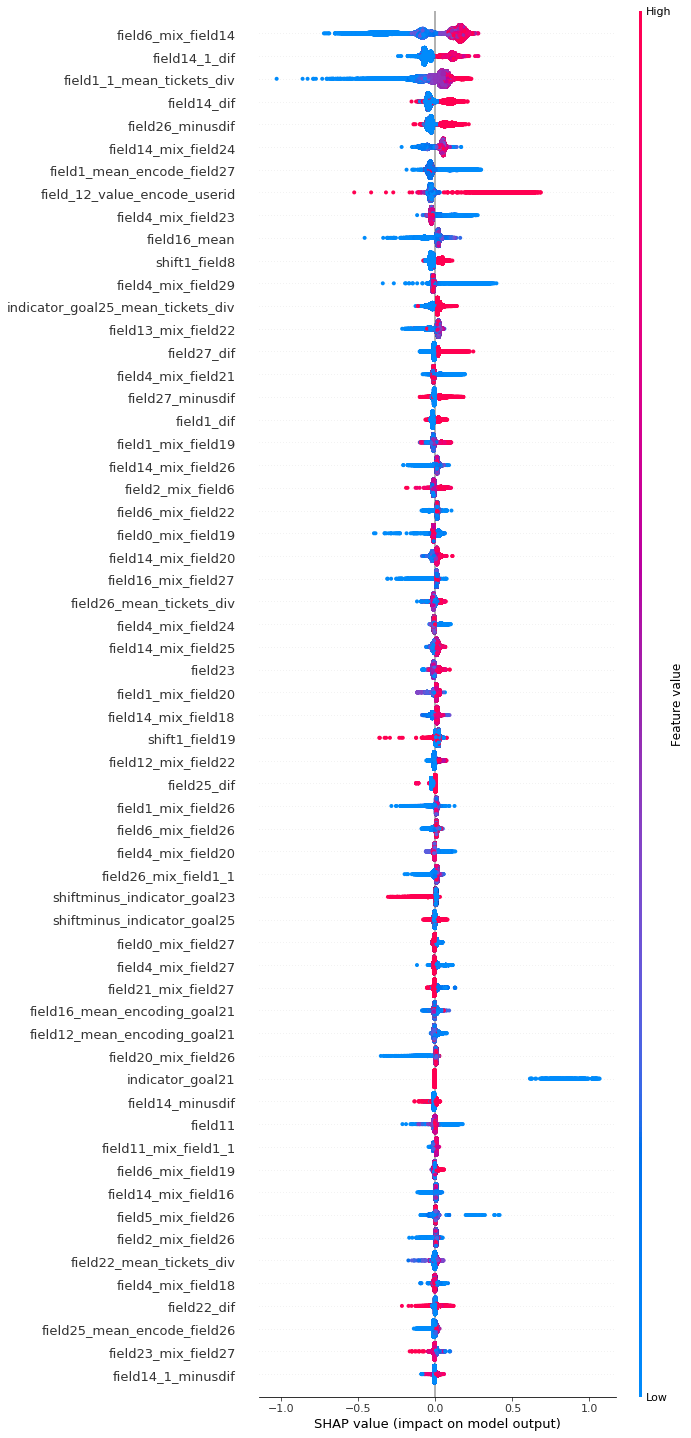

In [0]:
shap.summary_plot(shap_values[0], test[variable_names], max_display=60, plot_type='dot')

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


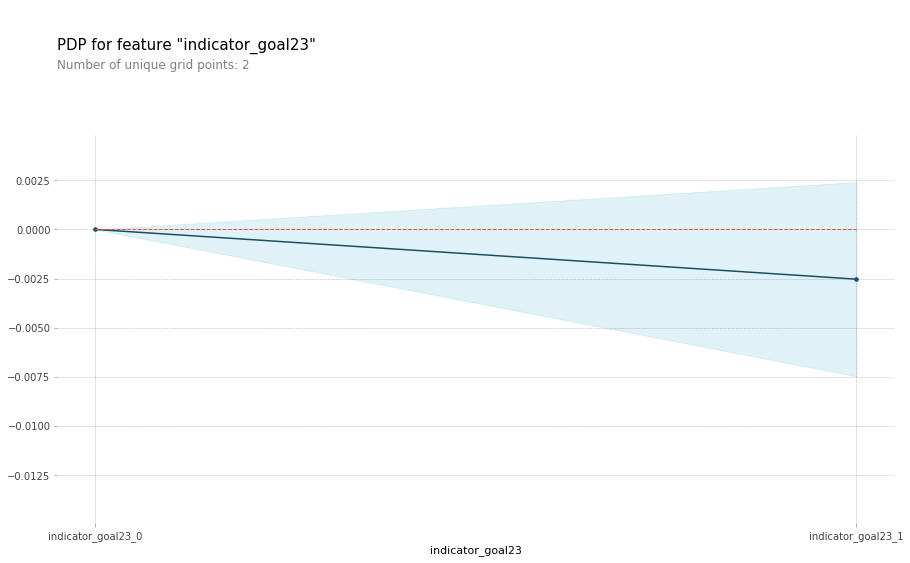

In [0]:
from pdpbox import pdp, get_dataset, info_plots
test_1 = test[variable_names]

pdp_goals = pdp.pdp_isolate(model=lgb_cl, dataset=test_1, model_features=test_1.columns, feature='indicator_goal23')

# plot it
pdp.pdp_plot(pdp_goals,'indicator_goal23')
plt.show()


In [0]:
!pip install pdpbox

     |████████████████████████████████| 57.7MB 38kB/s 
  Created wheel for pdpbox: filename=PDPbox-0.2.0-cp36-none-any.whl size=57690723 sha256=d33abfe9ff83ab140c72399a41f813473bea9345499c090d5707bbd8aa7c3d5c
  Stored in directory: /root/.cache/pip/wheels/7d/08/51/63fd122b04a2c87d780464eeffb94867c75bd96a64d500a3fe
Successfully built pdpbox


### Сабмит

In [0]:
df_train.isnull().sum().sum(), df_test.isnull().sum().sum()

(0, 0)

In [0]:
import gc
gc.collect()

36

In [0]:
targets = ['goal21', 'goal22', 'goal23', 'goal24', 'goal25']

In [0]:
for target in targets:
    lgb_cl.fit(df_train[variable_names], df_train[target])
    scr = lgb_cl.predict_proba(df_test[variable_names])[:,1]
    df_test[target] = np.round(scr,4)
    df_test[target] = df_test[target]*df_test['indicator_'+target]
    print(f'Target {target} learnt')

Target goal21 learnt
Target goal22 learnt
Target goal23 learnt
Target goal24 learnt
Target goal25 learnt


In [0]:
df_test[['orderid', 'goal21', 'goal22', 'goal23', 'goal24', 'goal25']].to_csv(os.path.join(subm_folder, 'new_mean_encode_div_features.csv'), index=False)

In [0]:
best_sub = pd.read_csv(os.path.join(subm_folder, 'best_submission.csv'))

In [0]:
best_sub = best_sub[['orderid', 'goal21', 'goal22']]

In [0]:
best_sub = best_sub.merge(df_test[['orderid', 'goal23', 'goal25', 'goal24']])

In [0]:
best_sub.head()

,orderid,goal21,goal24,goal23,goal25,goal22
0,0,0.0267,0.0000,0.0000,0.0027,0.1727
1,57972,0.0289,0.0128,0.0000,0.0789,0.1872
2,112638,0.0299,0.0000,0.0000,0.0000,0.1640
3,112639,0.0270,0.0270,0.0026,0.0007,0.2544
4,112640,0.0415,0.0621,0.0000,0.0005,0.2293


In [0]:
# best_sub[['orderid', 'goal21', 'goal22', 'goal23', 'goal24', 'goal25']].to_csv(os.path.join(subm_folder, 'add_tickets_features_mix_sub_27_goal23_25_24.csv'), index=False)
# best_sub[['orderid', 'goal21', 'goal22', 'goal23', 'goal24', 'goal25']].to_csv(os.path.join(subm_folder, 'add_tickets_features_mix_sub_27_goal23_25_24.csv'), index=False)

In [0]:
df_train[df_train.indicator_goal24==1].groupby('indicator_goal23')['goal24'].mean()

indicator_goal23
0    0.040225
1    0.025973
Name: goal24, dtype: float64

### Сабмит goal1


In [0]:
for target in ['goal1']:
    lgb_cl.fit(df_train[variable_names], df_train[target])
    scr = lgb_cl.predict_proba(df_test[variable_names])[:,1]
    df_test['proba'] = 1 - scr
    # df_test[target] = df_test[target]*df_test['indicator_'+target]
    print(f'Target {target} learnt')

Target goal1 learnt


In [0]:
df_test[['orderid', 'proba']].to_csv(os.path.join(subm_folder, 'saved_features_indicator_features.csv'), index=False)

## Стекинг сабмит

In [0]:
important_vars = features['fields_cols'] + features['ind_cols'] 
addition_features = features['just_cols'] + features['mix_cols'] + features['dif_cols'] + features['encode_cols'] + features['div_cols'] + features['shift_cols'] + new_count_cols + new_tickets_cols+new_time_groupby_cols

In [0]:
len(important_vars) + len(addition_features), len(addition_features)

(747, 710)

In [0]:
first_random_100 = random.sample(addition_features, k=150)
    
for col in first_random_100:
    addition_features.remove(col)

second_random_100 = random.sample(addition_features, k=150)

for col in second_random_100:
    addition_features.remove(col)

third_random_100 = random.sample(addition_features, k=150)

for col in third_random_100:
    addition_features.remove(col)

forth_random_100 = random.sample(addition_features, k=150)

In [0]:
targets = ['goal21', 'goal22', 'goal23', 'goal24', 'goal25']
for target in targets:
    preds = np.zeros((4, len(df_test)))
    for i, add_vars in enumerate([first_random_100, second_random_100, third_random_100, forth_random_100]):
        lgb_cl.fit(df_train[important_vars + add_vars], df_train[target])
        scr = lgb_cl.predict_proba(df_test[important_vars + add_vars])[:,1]
        preds[i] = scr
        print(f'{i} features on goal {target} learnt') 
    df_test[target] = np.round(np.mean(preds, axis=0),4)
    df_test[target] = df_test[target]*df_test['indicator_'+target]
    print(f'Target {target} learnt')
    print('-'*20)

0 features on goal goal21 learnt
1 features on goal goal21 learnt
2 features on goal goal21 learnt
3 features on goal goal21 learnt
Target goal21 learnt
--------------------
0 features on goal goal22 learnt
1 features on goal goal22 learnt
2 features on goal goal22 learnt
3 features on goal goal22 learnt
Target goal22 learnt
--------------------
0 features on goal goal23 learnt
1 features on goal goal23 learnt
2 features on goal goal23 learnt
3 features on goal goal23 learnt
Target goal23 learnt
--------------------
0 features on goal goal24 learnt
1 features on goal goal24 learnt
2 features on goal goal24 learnt
3 features on goal goal24 learnt
Target goal24 learnt
--------------------
0 features on goal goal25 learnt
1 features on goal goal25 learnt
2 features on goal goal25 learnt
3 features on goal goal25 learnt
Target goal25 learnt
--------------------


In [0]:
df_test[['orderid', 'goal21', 'goal22', 'goal23', 'goal24', 'goal25']].head()

,orderid,goal21,goal22,goal23,goal24,goal25
196056,0,0.0227,0.1734,0.0000,0.0000,0.0025
196057,247393,0.0143,0.0974,0.1286,0.0000,0.0028
196058,153432,0.0237,0.0702,0.0000,0.0346,0.0286
196059,158751,0.0134,0.1033,0.0000,0.0620,0.0005
196060,1,0.0123,0.0472,0.0000,0.0238,0.0324


In [0]:
df_test[['orderid', 'goal21', 'goal22', 'goal23', 'goal24', 'goal25']].to_csv(os.path.join(subm_folder, 'stacking_features_submission_4_samples.csv'), index=False)

### Объединение 2х сабмитов (не работает, видимо как и валидация)

In [0]:
best_subm = pd.read_csv(os.path.join(subm_folder, 'new_price_features.csv'))
second_subm = pd.read_csv(os.path.join(subm_folder, 'add_tickets_time_indicators_features.csv'))

In [0]:
best_subm.drop(['goal25', 'goal23'], axis=1, inplace=True)

In [0]:
best_subm = best_subm.merge(second_subm[['orderid','goal23', 'goal25']])

In [0]:
best_subm[['orderid', 'goal21', 'goal22', 'goal23', 'goal24', 'goal25']].to_csv(os.path.join(subm_folder, 'bland_2_best_submissions.csv'), index=False)